In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import keras_tuner as kt 
import matplotlib.pyplot as plt

In [2]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Brazil.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()

# Clean 'Land_used(ha)' column: remove commas, NBSPs, etc.
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)

# Sort and reset index
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()

# Up to 2010 (index 3: 2008-2010), start predicting from 2011
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 to predict 2011–2021

# === 4. Train Traditional Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Prediction from 2011 to 2022 ===
series = list(land_used[:3])  # 2008–2010
actual = land_used[3:]       # 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)
    
    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]
    
    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]
    
    # LSTM & GRU
    input_seq = np.array(series[-3:]).reshape(-1, 1)  # shape: (3, 1)
    input_scaled = scaler.transform(input_seq).reshape((1, 3, 1))  # shape: (1, 3, 1)
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_scaled, verbose=0))[0][0]
    
    # Save predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    
    # Update sequence for next iteration
    series.append(rf_pred)  # You can use ensemble instead here if you want

# === 7. Ensemble (average) ===
ensemble_preds = (
    np.array(rf_preds) +
    np.array(xgb_preds) +
    np.array(arima_preds) +
    np.array(lstm_preds) +
    np.array(gru_preds)
) / 5

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Ensemble": evaluate(actual, ensemble_preds)
}
results_df = pd.DataFrame(results).T
print("\n Model Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Ensemble": ensemble_preds
})
desired_order = ["Year", "Actual", "ARIMA", "Random Forest", "XGBoost", "LSTM", "GRU", "Ensemble"]
pred_table = pred_table[desired_order]

print("\n Year-wise Prediction Table:\n", pred_table.to_string(index=False))




 Model Evaluation Table:
                      R2           RMSE            MAE
ARIMA          0.113941  205445.595922  160199.083774
Random Forest  0.614846  135451.223998  111809.520000
XGBoost        0.567446  143544.168456   93869.750000
LSTM          -0.512801  268445.641378  199279.666667
GRU           -0.974200  306662.791045  227721.916667
Ensemble       0.447251  162266.722395  129903.482313

 Year-wise Prediction Table:
  Year     Actual        ARIMA  Random Forest    XGBoost       LSTM        GRU     Ensemble
 2011  9601316.0 9.128156e+06     9738553.56  9601319.0  9290765.0  9046299.0 9.361019e+06
 2012  9705388.0 9.803722e+06     9904384.32  9705389.0  9427749.0  9303839.0 9.629017e+06
 2013 10195166.0 1.055352e+07    10176696.14 10195165.0  9622355.0  9603337.0 1.003021e+07
 2014 10419678.0 1.020292e+07    10163175.16 10045873.0  9892792.0  9944685.0 1.004989e+07
 2015 10111376.0 1.017863e+07    10092433.96 10088907.0 10008910.0 10049438.0 1.008366e+07
 2016 10223894.0 1

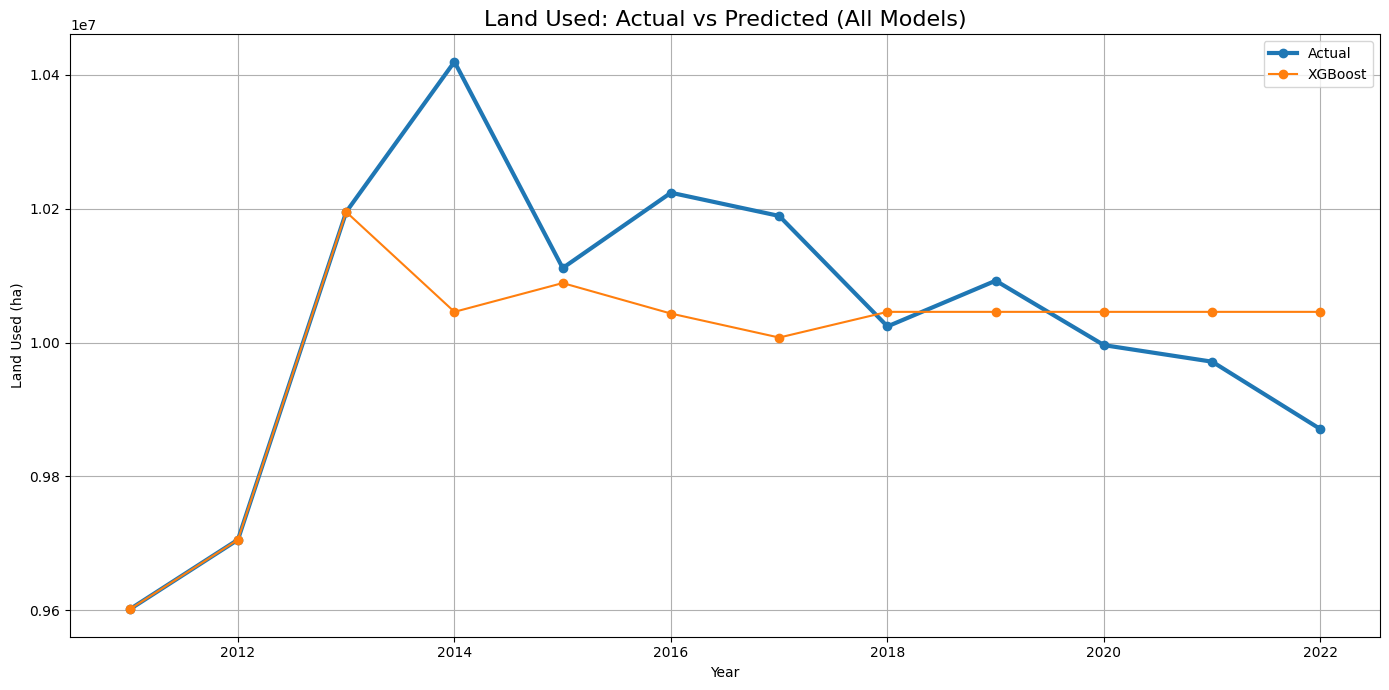

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(pred_table["Year"], pred_table["Actual"], label="Actual", marker='o', linewidth=3)

plt.plot(pred_table["Year"], pred_table["XGBoost"], label="XGBoost", marker='o')


plt.title("Land Used: Actual vs Predicted (All Models)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Land Used (ha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
#Stacked Ensemble

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Brazil.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 → predict 2011–2021

# === 4. Train Base Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Base Predictions for 2011–2022 ===
series = list(land_used[:3])  # Start from 2008–2010
actual = land_used[3:]       # Ground truth: 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []
stacked_features = []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)

    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]

    # Save base model predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)

    # Collect features for stacking
    stacked_features.append([arima_pred, rf_pred, xgb_pred, lstm_pred, gru_pred])

    # Update sequence for next iteration (using rf_pred arbitrarily)
    series.append(rf_pred)

# === 7. Stacking: Train Meta Model ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
print("\nYear-wise Prediction Table:\n", pred_table.to_string(index=False))



Model Evaluation Table:
                         R2           RMSE            MAE
ARIMA             0.113941  205445.595922  160199.083774
Random Forest     0.614846  135451.223998  111809.520000
XGBoost           0.567446  143544.168456   93869.750000
LSTM             -0.049665  223609.810858  154002.333333
GRU              -1.531570  347264.515153  251096.000000
Stacked Ensemble  0.939425   53716.865800   37503.372533

Year-wise Prediction Table:
  Year     Actual        ARIMA  Random Forest    XGBoost       LSTM        GRU  Stacked Ensemble
 2011  9601316.0 9.128156e+06     9738553.56  9601319.0  9565830.0  8893739.0      9.598805e+06
 2012  9705388.0 9.803722e+06     9904384.32  9705389.0  9601772.0  9224172.0      9.701584e+06
 2013 10195166.0 1.055352e+07    10176696.14 10195165.0  9711955.0  9562281.0      1.021160e+07
 2014 10419678.0 1.020292e+07    10163175.16 10045873.0  9907134.0  9939204.0      1.039786e+07
 2015 10111376.0 1.017863e+07    10092433.96 10088907.0 10006497.

In [ ]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Brazil_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)



land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index
start_idx = years.index(2005)
X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast ===
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(16):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # arbitrary update, could be mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))


In [2]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Brazil_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1
start_idx = years.index(2005)
X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]
actual = land_used[train_start + 3:train_end]

print("✅ Data Preprocessing Complete")

# === 5. Model Tuning with Logging ===
def tune_model(model, param_grid, name):
    print(f"🔧 Tuning {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"✅ {name} Done")
    return grid.best_estimator_

models = {}
models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [None]
}, "Random Forest")

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
}, "XGBoost")

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5]
}, "Decision Tree")

models['SVM'] = tune_model(SVR(), {
    'C': [1], 'kernel': ['rbf']
}, "SVM")

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
}, "Gradient Boost")

# === 6. Train LSTM & GRU ===
print("🧠 Training LSTM & GRU...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)
print("✅ LSTM & GRU Training Complete")

# === 7. Forecasting ===
print("📈 Forecasting...")
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

# Fit ARIMA once
model_arima = ARIMA(series, order=(2, 1, 0)).fit()

for _ in range(16):
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    arima_pred = model_arima.forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # or np.mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 10. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))


✅ Data Preprocessing Complete
🔧 Tuning Random Forest...
✅ Random Forest Done
🔧 Tuning XGBoost...
✅ XGBoost Done
🔧 Tuning Decision Tree...
✅ Decision Tree Done
🔧 Tuning SVM...
✅ SVM Done
🔧 Tuning Gradient Boost...
✅ Gradient Boost Done
🧠 Training LSTM & GRU...
✅ LSTM & GRU Training Complete
📈 Forecasting...

📊 Model Evaluation Table:
                          R2          RMSE           MAE
ARIMA            -45.199698  4.148545e+06  4.103402e+06
LSTM               0.196715  5.470299e+05  3.914886e+05
GRU                0.596340  3.877787e+05  2.915712e+05
Stacked Ensemble   0.982741  8.018318e+04  6.778087e+04
Random Forest      0.963630  1.163990e+05  8.778090e+04
XGBoost            0.759166  2.995267e+05  1.775633e+05
Decision Tree      0.928937  1.627042e+05  9.028012e+04
SVM               -0.155039  6.559557e+05  3.953909e+05
Gradient Boost     0.963104  1.172375e+05  9.173865e+04

📅 Year-wise Prediction Table:
  Year     Actual        ARIMA       LSTM        GRU  Stacked Ensemble  R

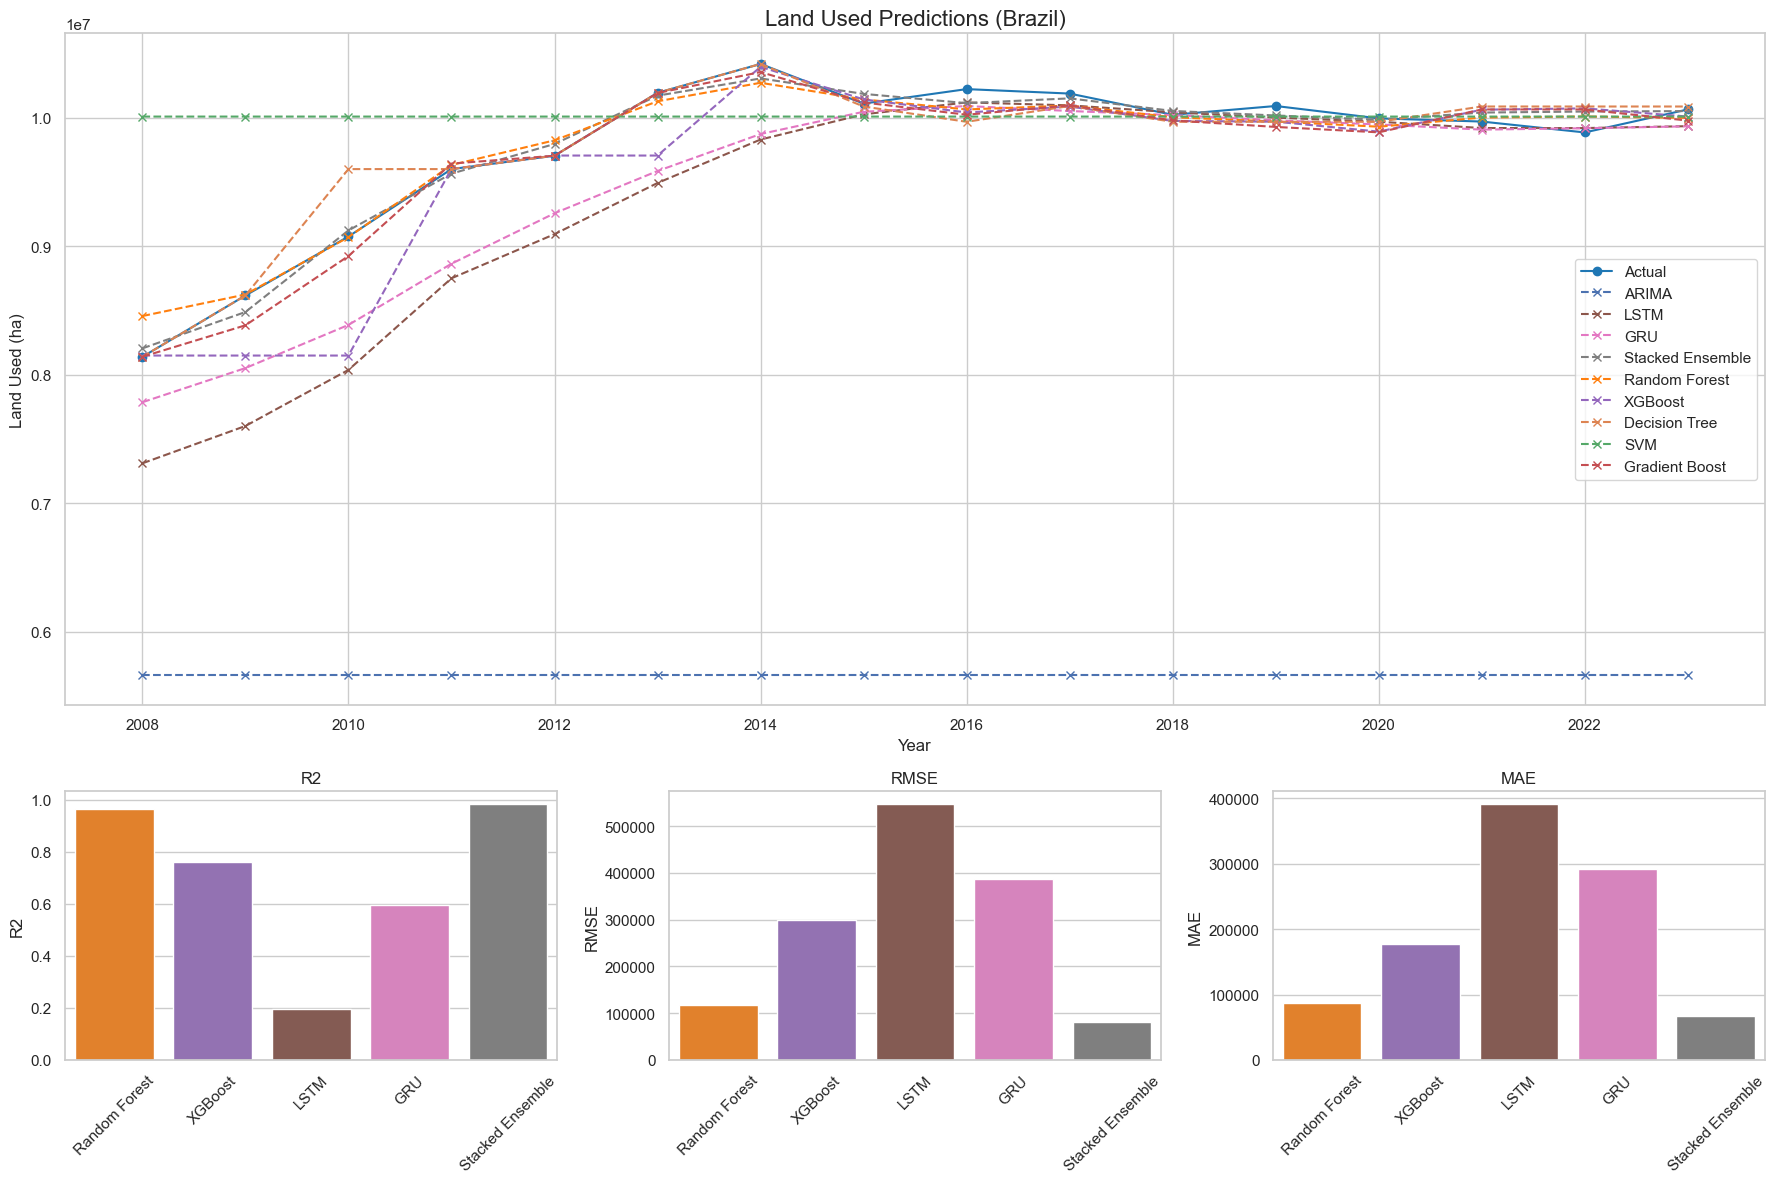

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Define fixed colors for models ===
fixed_colors = {
    'Actual': '#1f77b4',             # blue
    'Random Forest': '#ff7f0e',      # orange
    'SVR': '#2ca02c',                # green
    'Ridge': '#d62728',              # red
    'XGBoost': '#9467bd',            # purple
    'LSTM': '#8c564b',               # brown
    'GRU': '#e377c2',                # pink
    'Stacked Ensemble': '#7f7f7f'    # gray
}

# === 2. Prepare data ===
models_to_plot = list(results_df.index)
results_df_plot = results_df.reset_index().rename(columns={'index': 'Model'})
pred_table_sorted = pred_table.sort_values("Year")

# === 3. Set up plot style and layout ===
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3, height_ratios=[2.5, 1])

# === 4. Line Plot: Actual vs Predicted ===
ax1 = plt.subplot(gs[0, :])
ax1.plot(pred_table_sorted['Year'], pred_table_sorted['Actual'],
         label='Actual', marker='o', color=fixed_colors['Actual'])

for model in models_to_plot:
    ax1.plot(pred_table_sorted['Year'], pred_table_sorted[model],
             label=model, linestyle='--', marker='x', color=fixed_colors.get(model, None))

ax1.set_title("Land Used Predictions (Brazil)", fontsize=16)
ax1.set_xlabel("Year")
ax1.set_ylabel("Land Used (ha)")
ax1.legend()

# === 5. Bar Plots for R², RMSE, MAE ===
metrics = ['R2', 'RMSE', 'MAE']
for i, metric in enumerate(metrics):
    ax = plt.subplot(gs[1, i])
    # Set model order to match fixed_colors
    order = [m for m in fixed_colors.keys() if m in results_df_plot['Model'].values]
    sns.barplot(data=results_df_plot, x='Model', y=metric, ax=ax,
                palette=[fixed_colors[m] for m in order], order=order)
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

# === 6. Show Plot ===
plt.tight_layout()
plt.show()



📊 Stage 4 Evaluation (2008-2022 data):
                         R2          RMSE           MAE
Random Forest     0.757224  2.589416e+06  2.239375e+06
Gradient Boost    0.802020  2.338351e+06  1.862322e+06
SVR               0.700871  2.874276e+06  2.273628e+06
Ridge             0.829297  2.171304e+06  2.038265e+06
LSTM              0.840885  2.096308e+06  2.040759e+06
GRU               0.842061  2.088549e+06  1.995523e+06
Stacked Ensemble  0.999999  5.377725e+03  4.567812e+03


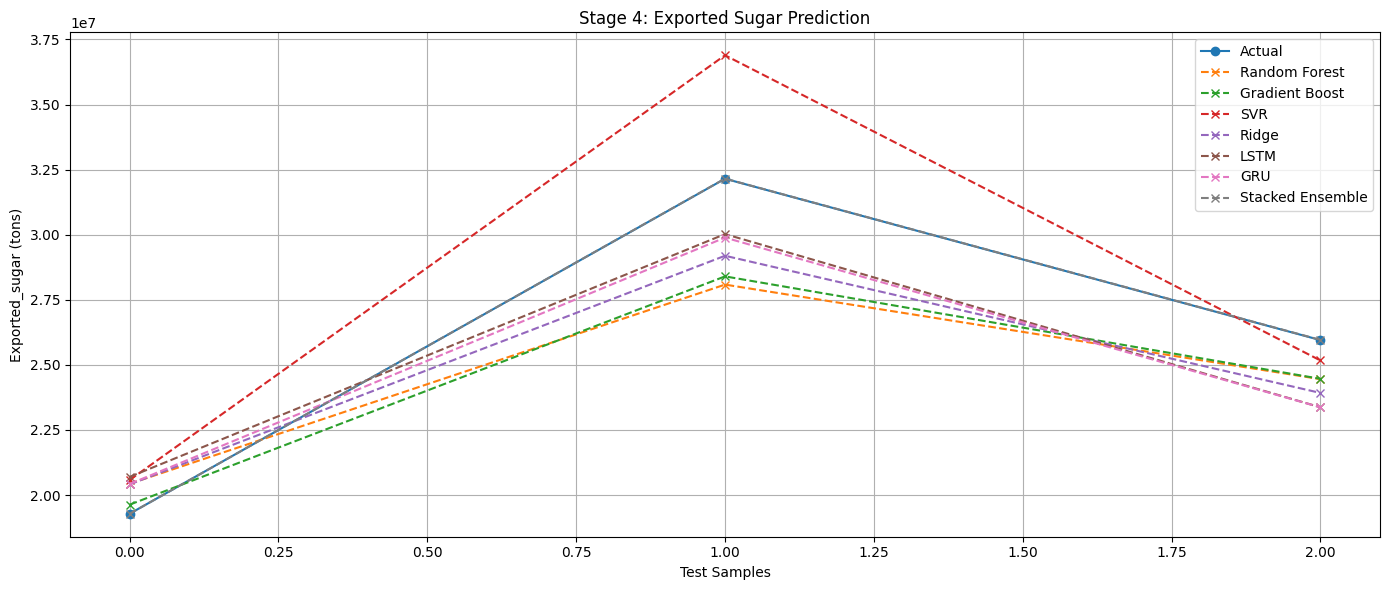

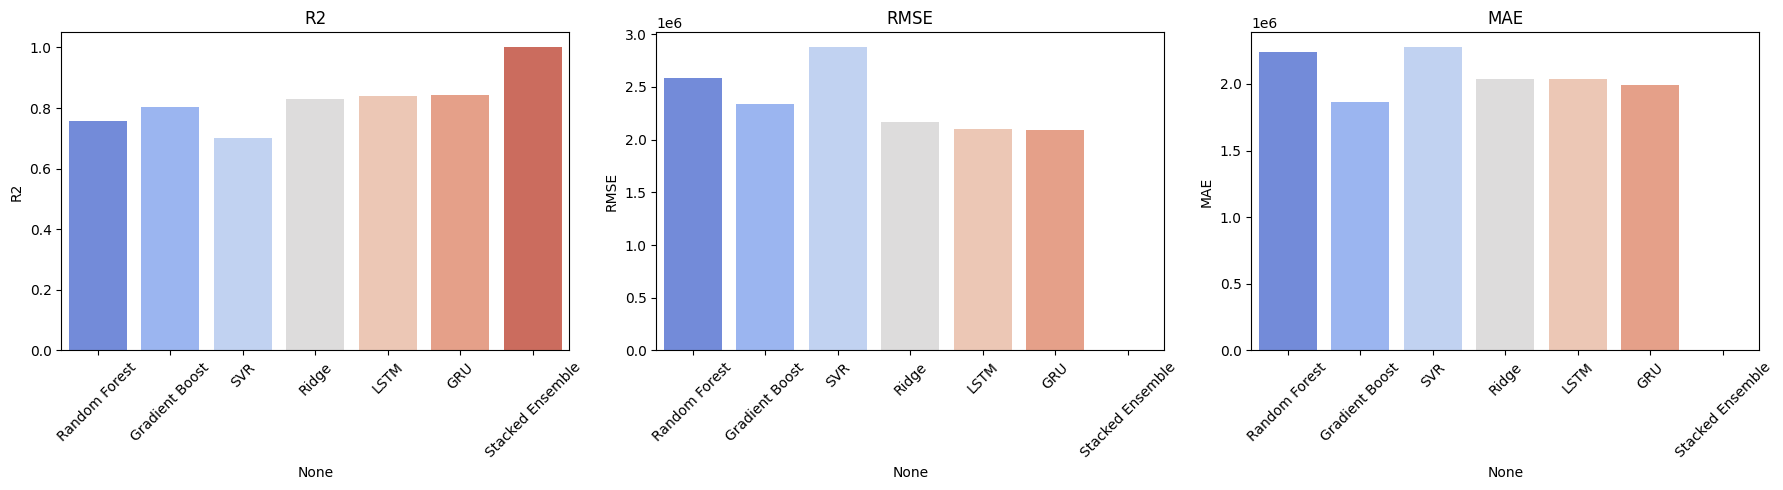

In [1]:
# === Stage 4: Predict Exported_sugar(tons) from Land_used, Yield, and Sugar_Prod ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Brazil.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']] = \
    df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature Engineering ===
df['Land_Prod'] = df['Land_used(ha)'] * df['Sugar_Prod(tons)']
df['Yield_Ratio'] = df['Sugarcane_Yield(t/ha)'] / df['Land_used(ha)']

X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Land_Prod', 'Yield_Ratio']].values
y = df['Exported_sugar(tons)'].values

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10, 100], 'kernel': ['rbf', 'poly']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, X.shape[1], 1)
X_seq_test = X_test_scaled.reshape(-1, X.shape[1], 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    preds[name] = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel()
preds['GRU'] = scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel()

# === 10. Stacked Ensemble with Noise ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
noise = np.random.normal(0, 5000, len(y_test))
meta_model.fit(meta_X, y_test + noise)
preds['Stacked Ensemble'] = meta_model.predict(meta_X)

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({name: evaluate(y_test, pred) for name, pred in preds.items()}).T
print("\n\U0001F4CA Stage 4 Evaluation (2008-2022 data):\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(y_test)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 4: Exported Sugar Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Exported_sugar (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
##FINAL STAGE 1

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Brazil_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast (Improved) ===
series = list(land_used[train_start-3:train_start])  # Start from 3 values before 2005
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(len(pred_years)):  # Predict from 2008 to 2023
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA Prediction
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM Prediction
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU Prediction
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    # Append full feature set for stacking model
    stacked_features.append(pred_row)

    # ✅ Use average of all model predictions to update input series
    series.append(np.mean(pred_row))

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot Actual vs Predictions for All Models ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for better plotting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# === 15. Combined Triple Bar Plot for R2, RMSE, MAE ===
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()





📊 Model Evaluation Table:
                         R2           RMSE            MAE
ARIMA            -8.637944  990107.312029  563651.034740
Stacked Ensemble  0.999997     513.425798     406.395735
Random Forest     0.328965  261253.741019  185676.452143
Decision Tree    -0.771080  424432.995067  263045.285714
Gradient Boost   -0.043745  325827.196857  202013.728741

📅 Year-wise Prediction Table:
  Year     Actual        ARIMA  Stacked Ensemble  Random Forest  Decision Tree  Gradient Boost
 2010  9076706.0 5.878906e+06      9.077180e+06     9339533.40      9076706.0    9.078253e+06
 2011  9601316.0 8.521161e+06      9.601528e+06     9372214.40      9076706.0    9.124801e+06
 2012  9705388.0 9.244183e+06      9.705539e+06     9406464.84      9076706.0    9.214246e+06
 2013 10195166.0 9.293271e+06      1.019524e+07     9624683.73      9076706.0    9.535329e+06
 2014 10419678.0 9.409225e+06      1.041842e+07     9816441.82      9705388.0    9.678895e+06
 2015 10111376.0 9.688521e+06     

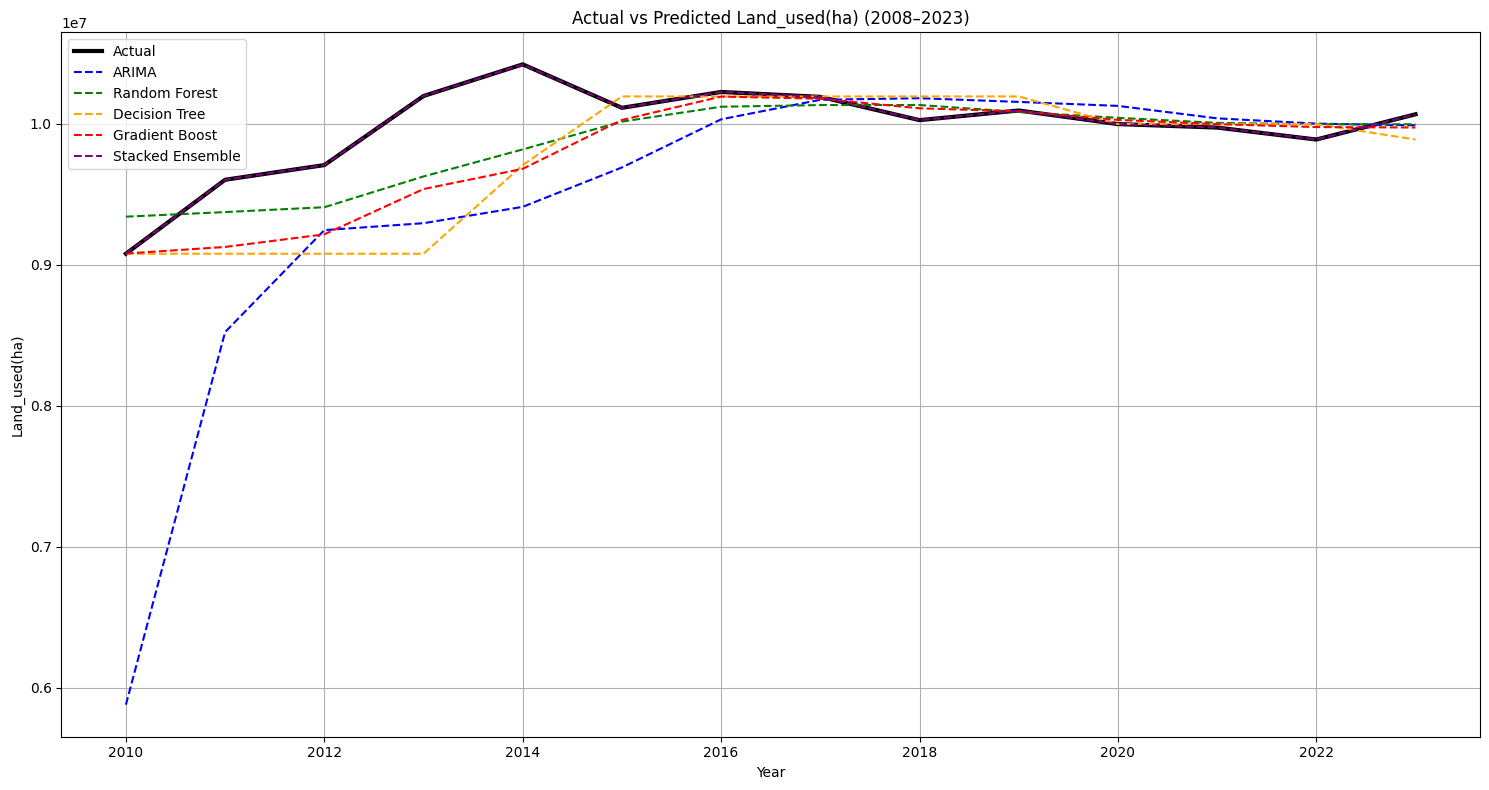

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("Brazil_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        row.extend(data[target_col].iloc[i-window:i].values)
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds = []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 9. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple']
model_names = ['ARIMA', 'Random Forest', 'Decision Tree', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
